Assignment 5: Classification in PyTorch
=======================================


Microsoft Forms Document: https://forms.office.com/r/4PAnYRs2Bf


Task 1: Dataset Loading
-----------------------

We use two different datasets, the spambase dataset https://archive.ics.uci.edu/ml/datasets/spambase for binary classification and the wine dataset https://archive.ics.uci.edu/ml/datasets/wine for categorical classification.
Both datasets are avaliable on the UCI Machine Learning repository.
In the first dataset, the target values are stored in the first column, while the rest is input.
For the second dataset, the target is stored in the last column, the rest is input.

我们使用两个不同的数据集，二进制分类的Spambase数据集https://archive.ics.uci.edu/ml/datasets/spambase，而分类的葡萄酒数据集https://archive.ics.uci.edu/ml/datasets/wine。
这两个数据集都可以在UCI机器学习资源库中找到。
在第一个数据集中，目标值被存储在第一列，而其余的是输入值。
对于第二个数据集，目标值存储在最后一列，其余为输入值。

When running with pytorch, samples should be stored as datatype ``torch.tensor``, and split between input sets $\mathbf X = [\vec x^{[1]}, \ldots, \vec x^{[N]}]^T \in \mathbb R^{N\times D}$ and targets.
There is **no need** to add a bias neuron to the input, and the transposition of the data matrix is different from what we have seen before.

For the targets, we have to be more careful as there are differences w.r.t. the applied loss function.
For binary classification, we need $\mathbf T = [[t^{[1]}, \ldots, t^{[N]}]]$ to be in dimension $\mathbb R^{N\times1}$ and of type ``torch.float``.
For categorical classification, we only need the class indexes $\vec t = [t^{[1]}, \ldots, t^{[N]}]$ to be in dimension $\mathbb N^N$ and of type ``torch.long``.

当用pytorch运行时，样本应存储为数据类型torch.tensor，并在输入集𝐗=[𝑥⃗[1],...,𝑥⃗[𝑁]]𝑇∈ℝ×𝐷和目标之间分割。不需要在输入中加入偏置神经元，而且数据矩阵的转置与我们之前看到的不同。

对于目标，我们必须更加小心，因为所应用的损失函数存在差异。对于二元分类，我们需要𝐓=[[𝑡[1],...,𝑡[𝑁]]的维度为ℝ𝑁×1，类型为Torch.float。对于多分类，我们只需要类索引𝑡⃗=[𝑡[1],...,𝑡[𝑁]]的维度为ℕ𝑁，类型为torch.long。

<font color="#dd0000">为什么 binary classification 要多一个维度呢？</font><br /> 

In [1]:
import os

import torch

# download the two dataset files
dataset_files = {
    "spambase.data": "https://archive.ics.uci.edu/ml/machine-learning-databases/spambase/",
    "wine.data": "https://archive.ics.uci.edu/ml/machine-learning-databases/wine/",
}
for name, url in dataset_files.items():
    if not os.path.exists(name):
        # urllib.request - 打开和读取 URL。
        import urllib.request

        # 获取并存储数据集到本地
        urllib.request.urlretrieve(url + name, name)
        print("Downloaded datafile", name)


def dataset(dataset_file="wine.data"):
    # read dataset
    data = []
    with open(dataset_file, "r") as f:
        for row in f:
            x = [float(x) for x in row.split(",")]
            data.append(x)

    print(f"Loaded dataset with {len(data)} samples")

    # convert to torch.tensor
    data = torch.tensor(data)

    if dataset_file == "wine.data":
        # target is in the first column and needs to be converted to long
        X = data[:, 1:]
        T = data[:, 0].long() - 1  # 改变原有的 label 1,2,3 =>>> 0,1,2 ?
    else:
        # target is in the last column and needs to be of type float
        X = data[:, :-1]
        T = data[:, -1].float().unsqueeze(dim=1)  # dim =>>> 在shape的什么地方插入一个空的dim，也就是 1
    return X, T

Test 1: Assert Valid Data
-------------------------

Load the wine dataset and make sure that the dataset is in the correct dimensions, i.e., $\mathbf X\in \mathbb R^{N\times D}$ and $\mathbf T \in \mathbb N^N$.
Also assure that all class labels are in the correct range $[0, O-1]$.

Load the spambase data and assure that all dimensions are correct and that class labels are in range $\{0, 1\}$.

In [2]:
# load email data
X, T = dataset("spambase.data")
# assert that everything is correct with the dataset
print(X.shape)
print(T.shape)
assert X.shape == (4601, 57)
assert T.shape == (4601, 1)
assert all(t >= 0 for t in T) and all(T <= 1)  ### 对于 tensor 或 np array这两种方法都可以

# load wine data
X, T = dataset("wine.data")
print(X.shape)
print(T.shape)
assert X.shape == (178, 13)
assert T.shape == (178,)
assert all(t == 0 or t == 1 or t == 2 for t in T)

# assert that everything is correct with the dataset

Loaded dataset with 4601 samples
torch.Size([4601, 57])
torch.Size([4601, 1])
Loaded dataset with 178 samples
torch.Size([178, 13])
torch.Size([178])


Task 2: Split Training and Validation Data
------------------------------------------

Write a function that splits off training and validation samples from a given dataset.
Use randomly 80% of the data for training, and 20% for validation.

What do we need to assure before splitting?


In [3]:
def split_training_data(X, T, train_percentage=0.8):
    # 注意要随机
    # torch.randperm(n) Returns a random permutation of integers from 0 to n - 1.
    idx_permutation = torch.randperm(X.shape[0])
    train_idx = idx_permutation[: int(train_percentage * X.shape[0])]
    val_idx = idx_permutation[int(train_percentage * X.shape[0]) :]

    X_train = X[train_idx]
    T_train = T[train_idx]
    X_val = X[val_idx]
    T_val = T[val_idx]

    return X_train, T_train, X_val, T_val

Task 3: Input Data Standardization
----------------------------------

Implement a function that standardizes all input data for the training and validation set.
Return the normalized data.
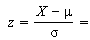

In [4]:
def standardize(X_train, X_val):
    # compute statistics
    mean = torch.mean(X_train, axis=0)  # 这里的 axis 很重要
    std = torch.std(X_train, axis=0)

    X_train = (X_train - mean) / std
    X_val = (X_val - mean) / std

    return X_train, X_val

Task 4: Network Implementation
------------------------------

Implement a function that returns a two-layer fully-connected network in pytorch.
Use tanh as activation function, and provide the possibility to change the number of inputs $D$, the number of hidden neurons $K$ and the number of outputs $O$.

In [5]:
# nn.Sequential 相当于创建了一个建议的小 model， 他按照顺序逐步自动向前传递，不用把前一个输出和后一个输入手动连上
# https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html


def Network(D, K, O):
    return torch.nn.Sequential(
        torch.nn.Linear(D, K), torch.nn.Tanh(), torch.nn.Linear(K, O)  ### 这里不需要加参数 K
    )

Task 5: Accuracy Computation
----------------------------

Implement a function that computes the accuracy of the provided network output (the logits) and the given target values.
Make sure that the implementation supports both binary as well as categorical targets.

In [6]:
def accuracy(Z, T):
    # check if we have binary or categorical classification
    if len(T.unique()) == 2:
        
        res = (torch.round(torch.sigmoid(Z)) == T).float().mean()

        return res

    else:
        # Z =
        # [[0.1, 0.6, 0.3],
        #  [0.8, 0.1, 0.1]]
        # T = 0 or 1 or 3

        return (torch.argmax(Z, axis=1) == T).float().mean()

Test 2: Test Accuracy Function
------------------------------

Design test data and according logit values with which you can test the correctness of your accuracy function.
Make sure that the accuracy will compute the correct values.
Test both binary and categorical accuracy.

In [8]:
# test binary classification
# ... design test logits and target values
Z = torch.tensor([3, 3, 3, -5, -5])
T = torch.tensor([1, 1, 0, 0, 1])
# ... test that the expected accuracy is computed
assert accuracy(Z, T) == 0.6

# test categorical classification
# ... design test logits and target values
Z = torch.tensor(
    [
        [0.1, 0.6, 0.3],  # 1
        [0.8, 0.1, 0.1],  # 0
        [0.1, 0.9, 0.0],  # 1
        [0.3, 0.4, 0.3],  # 1
        [0.2, 0.3, 0.5],
    ]
)  # 2
T = torch.tensor([2, 0, 1, 2, 2])

print(torch.argmax(Z, axis=1))
print(T)

assert accuracy(Z, T) == 0.6
# ... test that the expected accuracy is computed

tensor([1, 0, 1, 1, 2])
tensor([2, 0, 1, 2, 2])


Task 6: Training Loop
---------------------

Implement a function that takes all necessary parameters to run a training on a given dataset.
In this week, we will make use of the whole dataset in each training step, so we will perform gradient descent (not SGD), so there is no need to define anything related to batches.

For each epoch, compute the training set and the validation set accuracy, as well as their losses, and return all of them

实现一个函数，该函数需要所有必要的参数来对给定的数据集进行训练。在本周，我们将在每个训练步骤中使用整个数据集，所以我们将执行梯度下降（而不是SGD），所以不需要定义任何与批次有关的东西。

对于每个 epoch，计算训练集和验证集的准确度，以及它们的损失，并返回所有这些数据

In [9]:
def train(model, lr, momentum, epochs, X_train, T_train, X_val, T_val, loss_fn):
    optimizer = torch.optim.SGD(
        params = model.parameters(),
        lr = lr,
        momentum = momentum
    )

    # collect loss and accuracy values
    train_loss, train_acc, val_loss, val_acc = [], [], [], []

    for epoch in range(epochs+1):
        optimizer.zero_grad() ###### 一定要记得 optimizer.zero_grad()
        # train on training set
        # ... compute network output on training data
        Z = model(X_train)
        # ... compute loss from network output and target data
        loss = loss_fn(Z, T_train)
        # ... perform parameter update
        loss.backward()      ##### 一定要记得 loss.backward
        optimizer.step()
        
        # ... remember loss
            # loss.detach() 的requires_grad 为 false，得到的这个 Variable 永远不需要计算其梯度，不具有grad。
            # 相当于分离出一个不需要计算梯度的复制品
        train_loss.append(loss.detach().numpy()) ### 后面要作图，所以用numpy储存更方便？
    
        # ... compute training set accuracy
        acc = accuracy(Z.detach(), T_train).numpy()
        train_acc.append(acc)

        # test on validation data
        with torch.no_grad():
            # ... compute network output on validation data
            Z = model(X_val)
            # ... compute loss from network output and target data
            loss = loss_fn(Z, T_val)
            # ... remember loss
            val_loss.append(loss.detach().numpy())
            # ... compute validation set accuracy
            acc = accuracy(Z.detach(), T_val).numpy()
            val_acc.append(acc)

    # return the four lists of losses and accuracies
    return train_loss, train_acc, val_loss, val_acc

Task 7: Plotting Function
-------------------------

Implement a function that takes four lists containing the training loss, the training accuracy, the validation loss and the validation accuracy.
Plot the two losses into one plot, and the two accuracies into another plot.

In [10]:
from matplotlib import pyplot


def plot(train_loss, train_acc, val_loss, val_acc):
    pyplot.figure(figsize=(10, 3))
    ax = pyplot.subplot(121)
    ax.plot(train_loss, "g-", label="Training set loss")
    ax.plot(val_loss, "b-", label="Validation set loss")
    ax.legend()

    ax = pyplot.subplot(122)
    ax.plot(train_acc, "g-", label="Training set accuracy")
    ax.plot(val_acc, "b-", label="Validation set accuracy")
    ax.legend()

Task 8: Binary Classification
-----------------------------

Load the data for binary classification, using the ``"spambase.data"`` file.
Split the data into training and validation sets.
Standardize both training and validation input data.

Instantiate a network with the correct number of input neurons, a given number of $K$ hidden neurons and one output neuron.
Instantiate the binary cross entropy loss function.

Train the network with our data for 10'000 epochs and plot the training and validation accuracies and losses.

Loaded dataset with 4601 samples


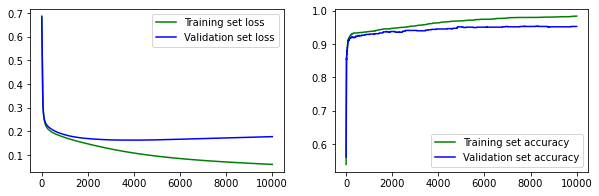

In [11]:
# define loss function
loss_fn = torch.nn.BCEWithLogitsLoss()
# load dataset
X, T =  dataset("spambase.data")
# split dataset
X_train, T_train, X_val, T_val = split_training_data(X, T, 0.8)
# standardize input data
X_train, X_val = standardize(X_train, X_val)
# instantiate network
model = Network(D = X.shape[1], K = 50, O = 1)

lr = 0.01
momentum = 0.9
epochs = 10000


# train network on our data
result = train(model, lr, momentum, epochs, X_train, T_train, X_val, T_val, loss_fn)

# plot the results
plot(*result)

Task 9: Categorical Classification
----------------------------------

Perform the same tasks with the ``"wine.data"`` dataset.
How many output neurons do we need?
Which loss function will we need this time?

How many hidden neurons will we need to get 100% training set accuracy?

Loaded dataset with 178 samples


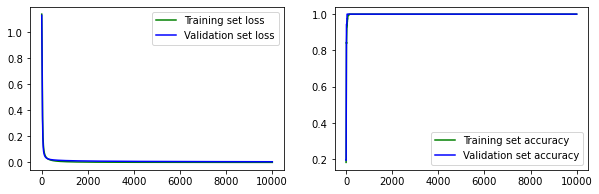

In [12]:
# define loss function
loss_fn = torch.nn.CrossEntropyLoss()
# load dataset
X, T = dataset("wine.data")
# split dataset
X_train, T_train, X_val, T_val = split_training_data(X, T, 0.8)

# standardize input data
X_train, X_val = standardize(X_train, X_val)
# instantiate network
model = Network(D = X.shape[1], K = 10, O = 3)

# train network on our data
result = train(model, lr, momentum, epochs, X_train, T_train, X_val, T_val, loss_fn)

# plot the results
plot(*result)